In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pysam

In [2]:
def load_snps(path, chrom, start, end):

    snvs = dict()
    with pysam.VariantFile(path) as f:
        name = list(f.header.samples)[0]
        for record in f.fetch(chrom, start, end):
            gt = record.samples[name]["GT"]
            ps = ""
            try:
                ps = record.samples[name]["PS"]
            except KeyError:
                pass
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]
            if len(record.ref) > 1 or len(a1) > 1 or len(a2) > 1:
                continue
            snvs[record.start] = [record.ref, a1, a2, ps]
    return snvs

[W::vcf_parse_format] FORMAT 'PS' at chr6:32519872 is not defined in the header, assuming Type=String
[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz.tbi


0 59 1329 895 63 1579


[W::vcf_parse_format] FORMAT 'PS' at chr6:32552360 is not defined in the header, assuming Type=String
[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz.tbi


0 56 238 293 206 310


[W::vcf_parse_format] FORMAT 'PS' at chr6:32578251 is not defined in the header, assuming Type=String
[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz.tbi


0 27 722 662 486 873


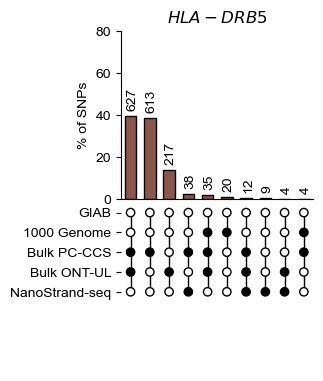

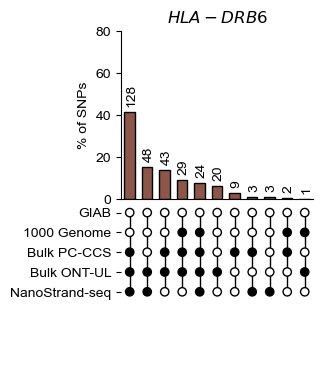

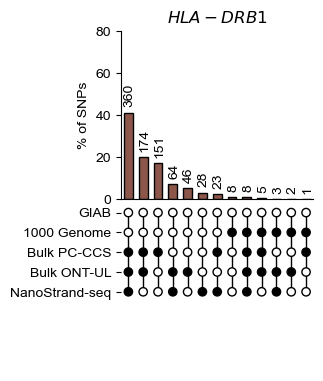

In [3]:
regions = [
    ["chr6", 32516840, 32530724, "HLA-DRB5"],
    ["chr6", 32552319, 32560405, "HLA-DRB6"],
    ["chr6", 32578223, 32590098, "HLA-DRB1"],
]

for chrom, start, end, gname in regions:

    snvs1 = load_snps("/lustre/grp/tfclab/chenzg/repositories/GRCh38_HG001_SNP_Indel/GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf.gz", chrom, start, end)
    snvs2 = load_snps("../../public/OneKG/NA12878.1kg.GRCh38.reheader.patmat.vcf.gz", chrom, start, end)
    snvs3 = load_snps("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/PacBio.full.vcf.gz", chrom, start, end)
    snvs4 = load_snps("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/Ultralong.full.vcf.gz", chrom, start, end)
    snvs5 = load_snps("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz", chrom, start, end)
    
    sites1 = set([(p, min(a1, a2), max(a1, a2)) for p, (ref, a1, a2, ps) in snvs1.items()])
    sites2 = set([(p, min(a1, a2), max(a1, a2)) for p, (ref, a1, a2, ps) in snvs2.items()])
    sites3 = set([(p, min(a1, a2), max(a1, a2)) for p, (ref, a1, a2, ps) in snvs3.items()])
    sites4 = set([(p, min(a1, a2), max(a1, a2)) for p, (ref, a1, a2, ps) in snvs4.items()])
    sites5 = set([(p, min(a1, a2), max(a1, a2)) for p, (ref, a1, a2, ps) in snvs5.items()])
    sites6 = sites1 | sites2 | sites3 | sites4 | sites5
    print(len(sites1), len(sites2), len(sites3), len(sites4), len(sites5), len(sites6))

    array = []
    for site in sites6:
        b1 = site in sites1
        b2 = site in sites2
        b3 = site in sites3
        b4 = site in sites4
        b5 = site in sites5
        array.append(tuple([b1, b2, b3, b4, b5]))
    counter = Counter(array)
    
    items = list(sorted(Counter(array).items(), key=lambda item: item[1], reverse=True))
    total = len(array)

    xs = np.arange(len(items))
    counts = [item[1] for item in items]
    ys = np.array(counts) * 100 / total

    fig, axs = plt.subplots(2, 1, figsize=(3.5, 4), sharex=True, 
                            gridspec_kw={"hspace": 0.02, "left": 0.4, "right": 0.95, "bottom": 0.05, "top": 0.9})

    # 
    ax = axs[0]
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.sca(ax)
    plt.title("$\it{%s}$" % gname)
    plt.bar(xs, ys, edgecolor="black", color="C5", width=0.6)
    for x, y, count in zip(xs, ys, counts):
        plt.text(x + 0.1, y + 4, format(count, ","), ha="center", rotation=90)
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.ylim(0, 80)
    plt.ylabel("% of SNPs")

    #
    ax = axs[1]
    for x in ax.spines.values():
        x.set_visible(False)
    plt.sca(ax)
    xs = []
    ys = []
    colors = []
    for i, item in enumerate(items):
        s = item[0]
        for j, c in enumerate(s):
            xs.append(i)
            ys.append(j)
            if c:
                color = "black"
            else:
                color = "white"
            colors.append(color)
        plt.plot([i, i], [0, 4], lw=1, color="black", zorder=1)
    plt.scatter(xs, ys, color=colors, edgecolor="black", zorder=2)
    plt.yticks([0, 1, 2, 3, 4], ["GIAB", "1000 Genome", "Bulk PC-CCS", "Bulk ONT-UL", "NanoStrand-seq"])
    plt.xticks([])

    plt.ylim(8, -0.5)
    #plt.show()
    #plt.close()
    plt.savefig("figures/benchmark_of_%s.pdf" % gname, dpi=300)